# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

<img src="https://image.freepik.com/free-vector/cartoon-delivery-man-brings-goods-customer-from-laptop-vector-illustration-concept-with-online-shopping-services_46527-344.jpg" />

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

## Problem Statement

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

## Executive Summary

The data is webscrapped from the Shopping category in Google Play Store and Apple Appstore, 8 apps reviews were chosen for this project (Amazon, Wish, ASOS, Lazada, Ebay, Shoppee, AliExpress, Carousell). The data used was exclusive dated in 2020 only as majority of the data scrapped are from in 2020. Data cleaning was done by removing stopwords, lemmatized and Vectorized to the raw data to create bag-of-words. 

There will be 3 steps to our modelling process, with the first step classifying whether the text is a good or bad review, followed by classifying the reviews into categories created through topic modelling to group them into different subgroups.

A few classification model were used, namely LogisticRegression, MultinomialNB, SGDClassifier, RandomForest, ADABoost. LogisticRegression give us the best results in classifying our data and thus used as the final model. 

As the data set is quite big, RandomizedSearch was used instead of Gridsearch to find the best hyperparameter.



### Content Summary
- Webscrapped reviews of 8 apps from Google Play Store & Apple App Store
- Data Cleaning 
  - Removing data not in year 2020
  - Removing emoji and punctuations
  - Removing non english words
  - Lemmatization
  - Compound score calculation using VaderSentiment
- EDA
  - Plotting distribution of features
  - Topic modelling of good reviews
  - Topic modelling of bad reviews
- Machine Learning Model 
  - LogisticRegression
  - MultinomialNB
  - SGDClassifier
  - RandomForest
  - ADABoost
- Deep Learning Model
  - Convolutional Neural Network
  
### Key Findings
- Most complains are on Bad User Experience, while most good reviews are on the good overall service of the App, which is rather vague
- There is more negative reviews in 9am - 3pm period, and on Tuesdays
- There is quite a number of reviews being 1 word, or otherwise rated wrongly by the user, (e.g. review: Excellent, Rating: 1)
- The multiclass model seems to be predicting better compared to what the topic modeling originally set the topic was, which is quite interesting as the model is able to differentiate the categories clearly base on the keywords.

### Metrics
Using the following metrics to evaluate the models:
- ROC AUC curve(for Binary Classification)
  -  The ROC AUC cruve is able to tell how much model is capable of distinguishing between classes.ranging from 0 to 1, with 1 being perfectly classified.
- MCC Score
  - The Matthews correlation coefficient (MCC), instead, is a more reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives), proportionally both to the size of positive elements and the size of negative elements in the dataset.
- Kappa Score(For multiclassification)
  - Cohen’s Kappa is a quantitative measure of reliability for two raters that are rating the same thing, corrected for how often that the raters may agree by chance. ranging from 0 to 1, with 1 being good.
  
- f1 score weighted
  - The F1 Scores are calculated for each label and then their average is weighted by support - which is the number of true instances for each label. It can result in an F-score that is not between precision and recall

### Final Results
**Classification (Good & Bad Reviews)**
- LogisticRegression
  - Train data AUC: 0.947
  - Test data AUC: 0.945
  - MCC Score: 0.729
  
  
**Multi Classification (Bad Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.867	
    - Test Data f1 weighted score: 0.862	
    - MCC Score: 0.798336	
    - Kappa Score: 0.796888


**Multi Classification (Good Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.937	
    - Test Data f1 weighted score: 0.944	
    - MCC Score: 0.907	
    - Kappa Score: 0.906

### Limitations
- The data set is mostly collected in the month of August and September, which means the model is able to predict this period better, but not in predicting past data. 
- More data could be collected, as there is a major lack of Apple Appstore reviews compared to Google Play Store

### Further research
- Try to use Compound score gathered from VaderSentiment to do the classification instead, as we know there is some misclassified post by users. which hopefully give us a better accuracy.

### Content
1. Webscrap data
2. Data Cleaning
3. EDA
4. Model Part 1, Classification (Good & Bad Reviews)
5. Model Part 2, Multi Classification (Bad Review categories) 
6. Model Part 3, Multi Classification (Good Review categories)
7. Deep Learning Model

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.metrics import matthews_corrcoef, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle

In [2]:
df = pd.read_csv('../data/reviews_Model.csv')

In [3]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,...,neu_score,pos_score,compound_score,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,...,0.707,0.293,0.4404,9,3,20,26,47,8,Good Seller
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,...,0.408,0.592,0.4404,9,3,20,13,19,3,Good Overall Service
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase,first happy,purchase experience purchase,NaN,NaN,...,0.714,0.286,0.3400,9,3,20,11,57,7,Good Seller
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,...,0.715,0.285,0.4927,9,3,20,8,35,9,Good Overall Service
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,...,1.000,0.000,0.0000,9,3,19,37,16,3,Good Products


## Taking out all bad reviews for training

In [4]:
df[df['rating'] <= 3 ]['category'].value_counts(normalize = True)

Bad User Experience         0.485528
Bad Seller Reviews          0.216485
Bad Customer Service        0.172477
Account & Payment Issues    0.085186
App Issues                  0.040324
Name: category, dtype: float64

In [5]:
df = df[df['rating'] <= 3 ][['category', 'clean_content', 'review']]
df.head()

,category,clean_content,review
11,Bad User Experience,stupid bubble game impossible tap bubble chang...,Stupid shoppee bubble game. Impossible. When t...
40,Bad User Experience,recent update shoppe bubble game unplayable li...,Recent update make shoppe bubble game unplayab...
69,Bad Customer Service,d come contact live chat rep purposely waste t...,Was quite ok with d app until I came into cont...
122,Account & Payment Issues,aware manage beat claim certain voucher able u...,Be aware that even though you managed to beat ...
139,Bad Seller Reviews,delete account receive defective item seller g...,Deleted the app and my account. Received sever...


In [6]:
#Checking null values
df.isna().sum()

category         0
clean_content    0
review           0
dtype: int64

## Train Test Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['category'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['category'])

In [8]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 12161, X_test rows: 3041
y_train rows: 12161, y_test rows: 3041


## Baseline Model

In [9]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
test_data_features = vectorizer.transform(X_test)

print(train_data_features.shape)
print(test_data_features.shape)

(12161, 5000)
(3041, 5000)


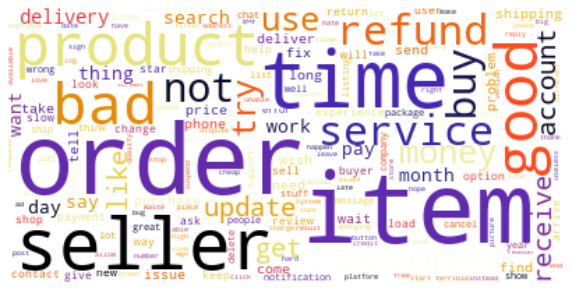

In [10]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='CMRmap')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.9677658087328345
Accuracy score for Test data set: 0.8589279842157185


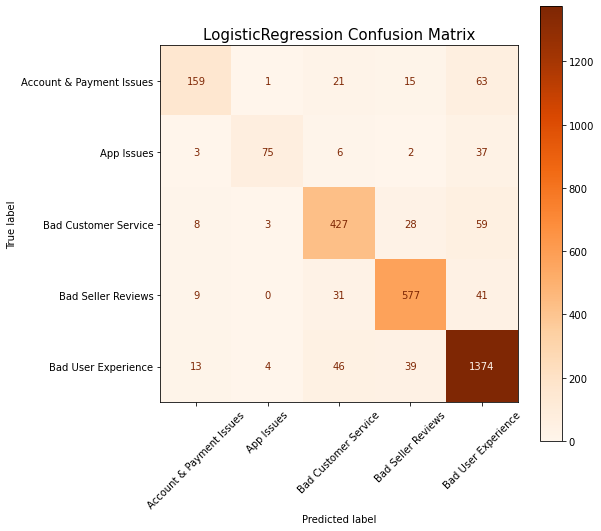

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(lr, test_data_features, y_test, ax = ax, cmap='Oranges', xticks_rotation=45);

In [13]:
print(classification_report(y_test, lr.predict(test_data_features), digits=3))

                          precision    recall  f1-score   support

Account & Payment Issues      0.828     0.614     0.705       259
              App Issues      0.904     0.610     0.728       123
    Bad Customer Service      0.804     0.813     0.809       525
      Bad Seller Reviews      0.873     0.877     0.875       658
     Bad User Experience      0.873     0.931     0.901      1476

                accuracy                          0.859      3041
               macro avg      0.856     0.769     0.804      3041
            weighted avg      0.858     0.859     0.856      3041



## Testing with different vectorizers

### CountVectorizer Logistic Regression

In [14]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
     ])

pipe_params = {
    'cvec__max_features': [7000, 8000],
    'cvec__min_df': [3, 4],
    'cvec__max_df': [.2 , .3,],
    'cvec__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_cvec_lr = RandomizedSearchCV(cvec_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best CVEC Parameters: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, max_features=7000, min_df=3)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  153.888s


### TFIDVectorizer Logistic Regression

In [15]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  150.294s


### HashingVectorizer Logistic Regression

In [16]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [6000, 7000],
    'hash__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_hash_lr = RandomizedSearchCV(hash_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\Sim Yi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 16 is smaller than n_iter=40. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


Best HASH Parameters: Pipeline(steps=[('hash', HashingVectorizer(n_features=6000)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  72.569s


In [17]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,
                gs_cvec_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_cvec_lr.predict(X_test)),
                round(cvec_test_time)])


summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,
                gs_hash_lr.score(X_test,y_test), 
                matthews_corrcoef(y_test, gs_hash_lr.predict(X_test)),
                round(hash_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,CountVectorizer,0.839490,0.839051,0.759552,154
1,LogisticRegression,TFIDVectorizer,0.853676,0.851874,0.783498,150
2,LogisticRegression,HashingVectorizer,0.834993,0.832704,0.755358,73


In [18]:
print(classification_report(y_test, gs_tfid_lr.predict(X_test), digits=3))

                          precision    recall  f1-score   support

Account & Payment Issues      0.553     0.807     0.656       259
              App Issues      0.984     0.496     0.659       123
    Bad Customer Service      0.786     0.859     0.821       525
      Bad Seller Reviews      0.864     0.878     0.871       658
     Bad User Experience      0.944     0.869     0.905      1476

                accuracy                          0.849      3041
               macro avg      0.826     0.782     0.782      3041
            weighted avg      0.868     0.849     0.852      3041



## Trying with Different Models

### Logistic Regression

In [19]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'lr__C': list(np.linspace(0, 10, 11))
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_lr_test_time = time() - t0
print(f'Best Logistic Regression Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_lr_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.6min finished


Best Logistic Regression Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])
Fit time:  218.489s


### MultinomialNB

In [20]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0,1,11))
}

gs_tfid_nb = RandomizedSearchCV(tfid_nb, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_nb.fit(X_train, y_train)
tfid_nb_test_time = time() - t0
print(f'Best MultinomialNB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_nb_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   45.3s finished


Best MultinomialNB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=5,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('nb', MultinomialNB(alpha=0.7000000000000001))])
Fit time:  46.407s


### SGDClassifier

In [21]:
# Setting pipeline for two stages
tfid_clf = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('clf', SGDClassifier())
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'clf__penalty': ('l2', 'elasticnet'),
    
    
}

gs_tfid_clf = RandomizedSearchCV(tfid_clf, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_clf.fit(X_train, y_train)
tfid_clf_test_time = time() - t0
print(f'Best SGDClassifier Parameters: {gs_tfid_clf.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_clf_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   49.1s finished


Best SGDClassifier Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('clf', SGDClassifier(penalty='elasticnet'))])
Fit time:  49.973s


### RandomForest

In [22]:
# Setting pipeline for two stages
tfid_ran = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('rf', RandomForestClassifier(random_state = 42, min_samples_leaf = 2, min_samples_split = 3))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [8, 15, 25],
    'rf__min_samples_split': [5, 15, 100],
    'rf__max_leaf_nodes': [10, None]
}

gs_tfid_ran = RandomizedSearchCV(tfid_ran, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ran.fit(X_train, y_train)
tfid_ran_test_time = time() - t0
print(f'Best RandomForest Parameters: {gs_tfid_ran.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ran_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.0min finished


Best RandomForest Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=8000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('rf',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=500,
                                        random_state=42))])
Fit time:  190.604s


### Adaboost

In [23]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'ada__n_estimators': [100,150,200],
    'ada__learning_rate': list(np.linspace(0.3,1,5))
}

gs_tfid_ada = RandomizedSearchCV(tfid_ada, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train, y_train)
tfid_ada_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ada_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.3min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=3,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.475, n_estimators=200))])
Fit time:  575.326s


### Accuracy & F1 Macro Score

In [24]:
summary = []

summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_lr_test_time)])


summary.append(['MultinomialNB', 'TFIDVectorizer', 
                gs_tfid_nb.best_score_,
                gs_tfid_nb.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_nb.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_nb.predict(X_test)),
                round(tfid_nb_test_time)])

summary.append(['SGDClassifier', 'TFIDVectorizer', 
                gs_tfid_clf.best_score_,
                gs_tfid_clf.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_clf.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_clf.predict(X_test)),
                round(tfid_clf_test_time)])

summary.append(['RandomForest', 'TFIDVectorizer', 
                gs_tfid_ran.best_score_,
                gs_tfid_ran.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ran.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_ran.predict(X_test)),
                round(tfid_ran_test_time)])



summary.append(['Adaboost', 'TFIDVectorizer', 
                gs_tfid_ada.best_score_,
                gs_tfid_ada.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ada.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_ada.predict(X_test)),
                round(tfid_ada_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'Kappa_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,Kappa_score,time(s)
0,LogisticRegression,TFIDVectorizer,0.867483,0.862574,0.798336,0.796888,218
1,MultinomialNB,TFIDVectorizer,0.813912,0.798171,0.710247,0.705691,46
2,SGDClassifier,TFIDVectorizer,0.847273,0.839600,0.766376,0.763378,50
3,RandomForest,TFIDVectorizer,0.700183,0.692704,0.564349,0.561264,191
4,Adaboost,TFIDVectorizer,0.716037,0.713104,0.574138,0.572783,575


## Confusion Matrix

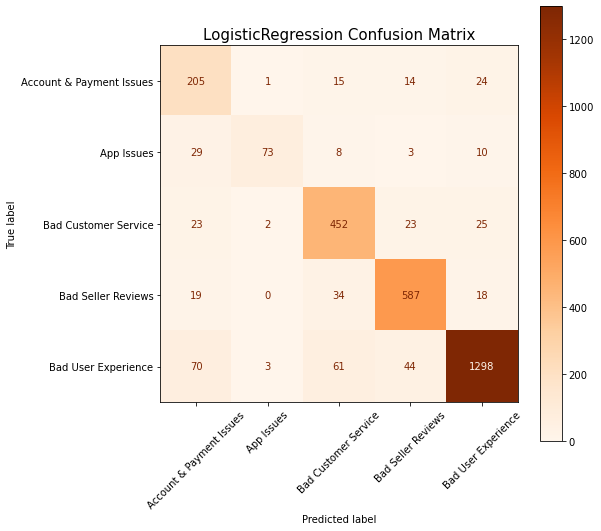

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_lr, X_test, y_test, ax = ax, cmap='Oranges', xticks_rotation=45);

## Checking Misclassified Post

In [26]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_lr.predict(X_test), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test
results['review'] = df['review']
results['clean_content'] = df['clean_content']

# Find all indices where predicted and true results 
# aren't the same, then save in an array.
ms_class = results[results['predicted']!= results['actual']]
ms_class.head(10)

,predicted,actual,review,clean_content
14317,Bad User Experience,Bad Seller Reviews,This system is the best place to sell expensiv...,system good place sell expensive mask control ...
47397,Account & Payment Issues,Bad Customer Service,Terrible customer service! My account was flag...,terrible customer service account flag fraud t...
47899,Account & Payment Issues,Bad User Experience,I enjoy the concept of an online shopping app ...,enjoy concept shopping large jeff need serious...
15325,Bad Seller Reviews,Bad Customer Service,"MY LOVE ORDER DEAR DIDN'T DELIVERED, IT ALMOST...",love order dear didn't month item delivery rep...
66410,Account & Payment Issues,Bad User Experience,Brilliant7,brilliant7
26806,Bad Seller Reviews,Bad User Experience,I faced Very differently to track product .it'...,face differently track product take time shipping
6210,Bad User Experience,Bad Customer Service,Slow and laggy on tablets. Have to press and w...,slow tablet press wait second respond strange ...
32203,Bad Seller Reviews,Bad User Experience,App works fine....more shipping/ receiving iss...,work fine shipping/ receive issue usually good...
19582,Account & Payment Issues,Bad User Experience,Scammer amp voucher pa,voucher pa
18707,Bad Seller Reviews,Bad User Experience,My orders were listed as refunded right after ...,order list right give star say stock problem o...


### Comments
- Some of the reviews are predicted wrongly. After looking at some of the reviews, it is clear that there are some misclassification by the topic modelling.
- It can be seen that the model is actually predicting better then what was classified in the first place.


## Train data on whole dataset

In [27]:
best_model = gs_tfid_lr.best_estimator_
best_model

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])

In [28]:
best_model.fit(df['clean_content'], df['category'])

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])

In [29]:
filename = 'Best_Model_BadReview_P2.sav'
pickle.dump(best_model, open('./model_pickles/' + filename, 'wb'))